# Trajectory inference using Slingshot

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is log
```

or

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```

```
sc.pp.filter_genes(adata_count, min_cells=3)
adata_count.write('data/anndata_forSeurat.h5ad')
```


In [2]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(Seurat)
library(dplyr)
library(slingshot)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)

Loading required package: princurve

Loading required package: splines

Loading required package: foreach

Loaded gam 1.16.1


Loading required package: Rcpp


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [3]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.0      harmony_1.0       
 [5] Rcpp_1.0.4.6       gam_1.16.1         foreach_1.5.0      destiny_3.2.0     
 [9] RColorBrewer_1.1-2 slingshot_1.6.0    princurve_2.1.4    dplyr_0.8.5       
[13] Seurat_3.1.5      

loaded via a namespace (

In [18]:
# we know these genes are relevant, use them to keep track on how good we're doing
known_genes = c("LGR6", "MKI67", "PAEP", "SCGB2A1", "SCGB1D2", "KRT5", "CXCL8", "LHX1", "KRT13", "SOX2", "PIFO", "FOXJ1")

# Process with Seurat from raw

In [21]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = 'data/organoids-all-TC-keep-ccg_forSeurat.h5ad')
allgenes = rownames(anndata)
anndata

Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
24241 features across 53720 samples within 1 assay 
Active assay: RNA (24241 features, 0 variable features)

In [22]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata, nfeatures = 2000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Centering and scaling data matrix



Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 1 features requested have not been scaled (running reduction without them): MLF1IP”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  MKI67, NUSAP1, TOP2A, HMGB2, CENPF, TPX2, UBE2C, BIRC5, SMC4, AURKB 
	   HMMR, DLGAP5, CENPA, CDK1, KIF20B, GTSE1, CCNB2, TACC3, CDC20, CDCA3 
	   RRM2, KIF23, AURKA, NDC80, CENPE, NUF2, TYMS, KIF2C, CDCA2, CDCA8 
Negative:  UBR7, CCNE2, POLA1, UNG, CASP8AP2, TIPIN, DTL, EXO1, WDR76, CHAF1B 
	   BRIP1, POLD3, CTCF, SLBP, RPA2, MSH2, MCM2, CDCA7, GAS2L3, G2E3 
	   MCM5, RANGAP1, RAD51, UHRF1, E2F8, CKAP5, BLM, MCM6, PRIM1, HN1 
PC_ 2 
Positive:  MCM6, PCNA, CLSPN, UNG, CDC6, MCM5, GINS2, HELLS, DTL, WDR76 
	   SLBP, FEN1, 

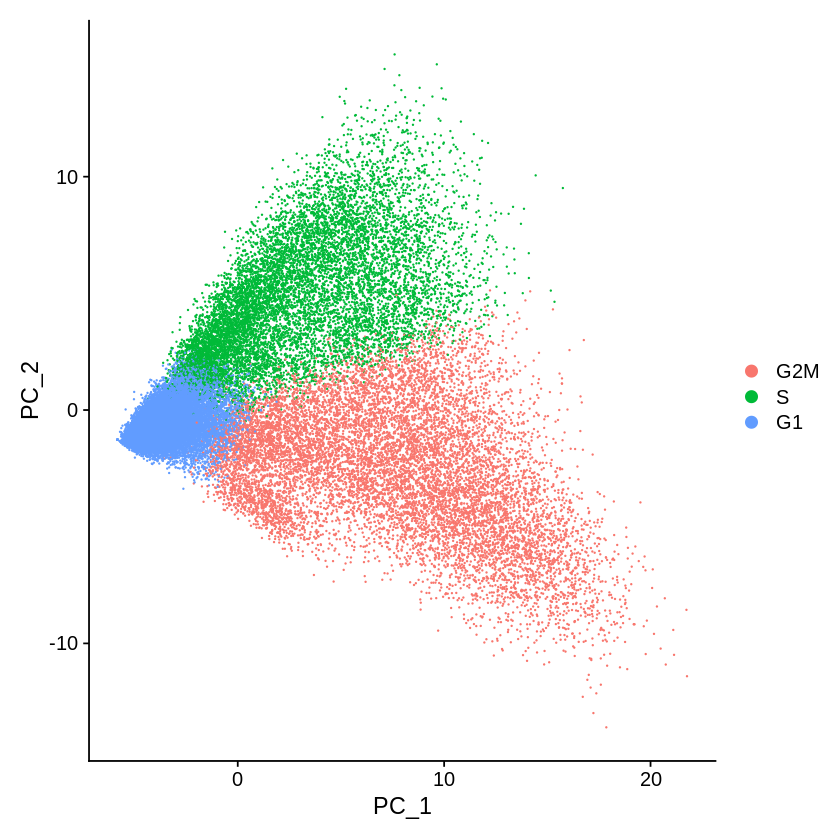

In [23]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [24]:
# # Regress out cell cycle - NOTE: subset the dataset to speed up process
# anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  TPPP3, FAM183A, ODF3B, FAM92B, SNTN, C11orf97, C1orf194, CCDC78, C9orf135, TUBA4B 
	   LRRC46, ROPN1L, CCDC170, MORN5, ZMYND10, FAM166B, C5orf49, FAM216B, DNAAF1, LRRC23 
	   TEKT1, RSPH9, CD164L2, RP11-356K23.1, PSENEN, CAPSL, EFCAB1, RSPH1, CFAP53, CFAP73 
Negative:  TUBB, PPP1R14B, KRT18, S100A16, CCND1, SRM, ODC1, TUBA1C, HMGA1, LMO4 
	   COTL1, RPL22L1, GLRX5, SOX4, ALDH1A1, FGF18, TPM1, CALD1, PHLDA1, ACAT2 
	   HLA-DMB, COL4A2, TPD52L1, FTL, TUBA4A, DBI, CD81, ARL4C, KIAA0101, ID4 
PC_ 2 
Positive:  RNASET2, TMPRSS3, TFF3, HSPB1, SCGB1D2, IFITM3, S100A14, C2orf88, SEPP1, NDRG1 
	   SLPI, SLC16A3, MUC5B, PGK1, EGLN3, ALDOA, KLK11, SCGB2A1, HLA-B, IFITM2 
	   BNIP3, WFDC2, S100A6, ALDOC, STC2, CA9, PLAUR, NDUFA4L2, AGR2, SNCB 
Negative:  HSP90AA1, ODC1, MT-ATP6, UBE2S, MT-CO2, PTTG1, ARL4C, KPNA2, MT-ND3, ALYREF 
	   DBI, MT-ND1, CD81, GLRX5, PPP1R14B, TMPO, MT-CYB, TOP2A, CENPF, KIF20B 
	   C12orf75, TUBA4A, MAP2K2, ALDH1A1, SRM, TPX2, HMGN3, APLP2, MAD2L1, TUBB

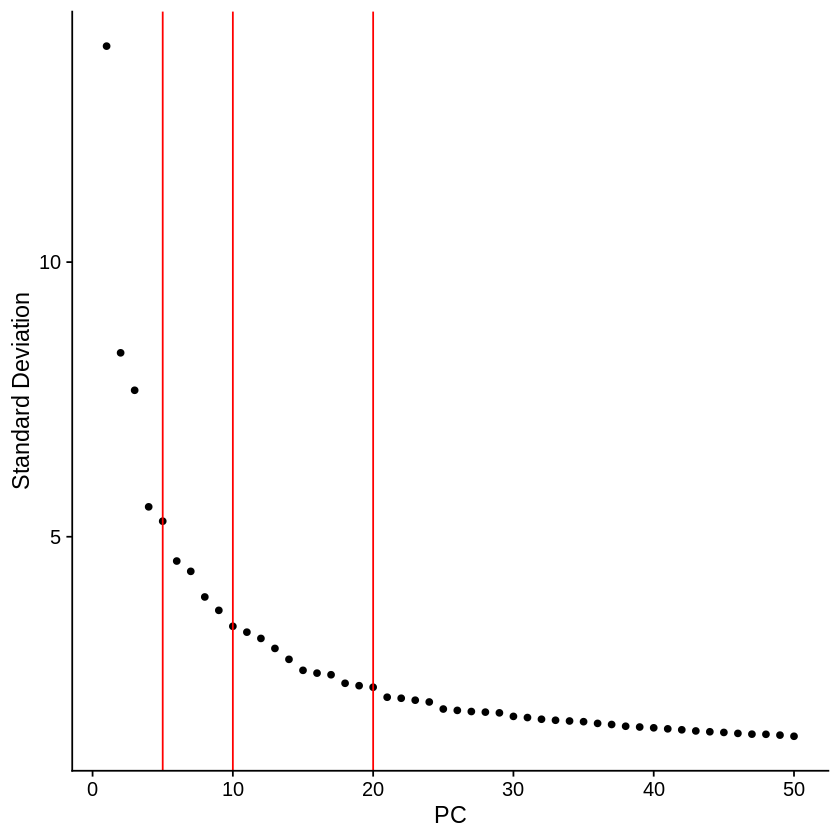

In [25]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [26]:
npca = 20
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'Donor', dims.use = 1:npca, theta = 2)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [27]:
# Cluster
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

In [28]:
anndata <- FindClusters(anndata, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 53720
Number of edges: 1616940

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8835
Number of communities: 12
Elapsed time: 17 seconds


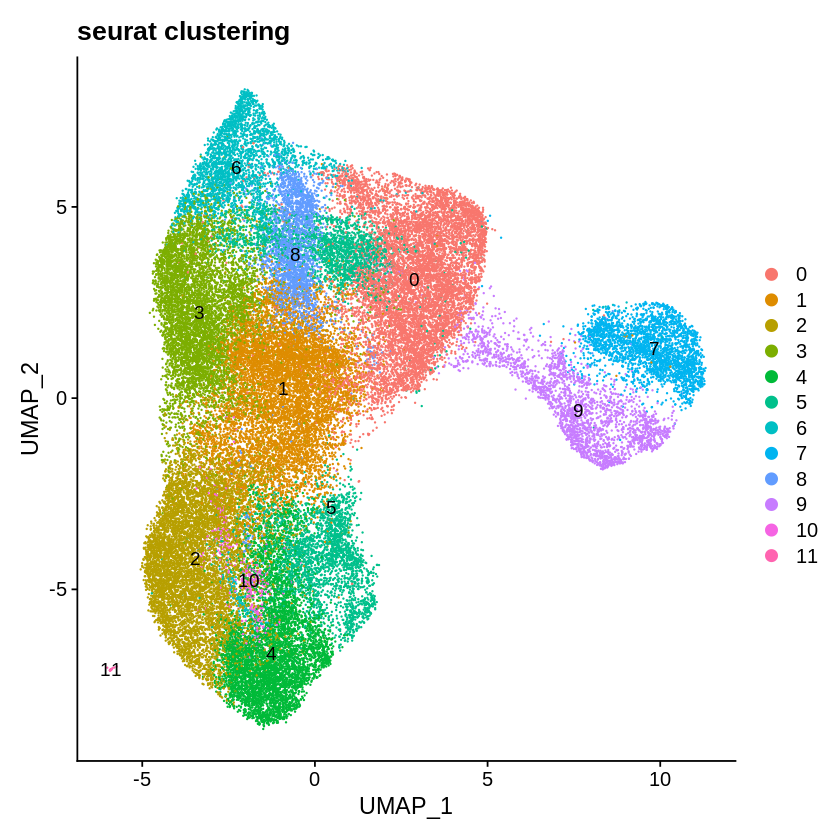

In [29]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T) + ggtitle('seurat clustering')
p1

Saving 6.67 x 6.67 in image



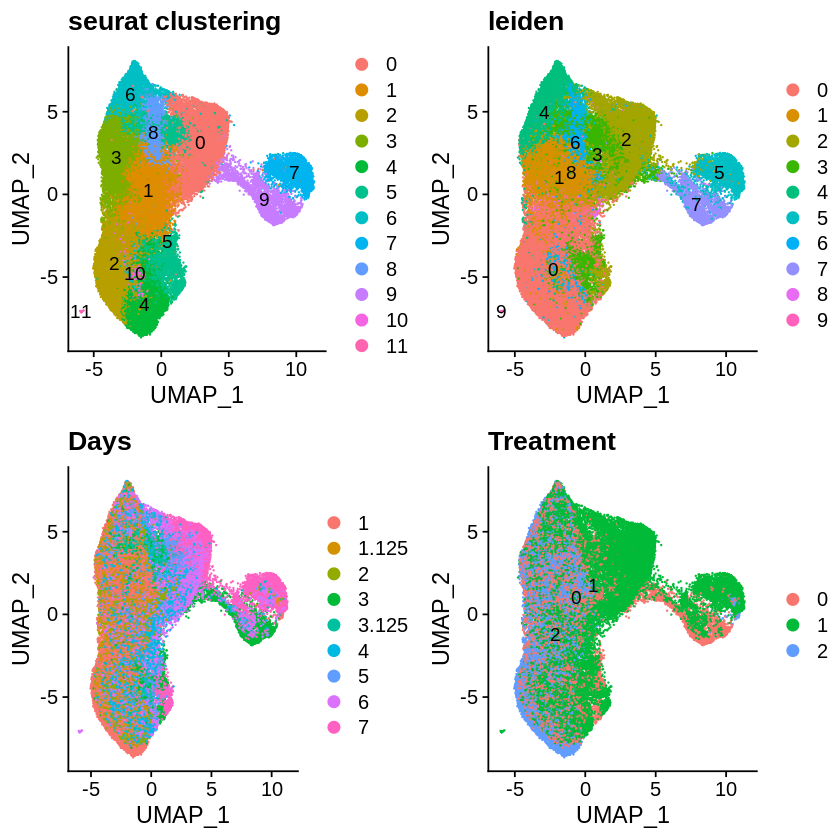

In [30]:
p2 = DimPlot(anndata, reduction = "umap", group.by = 'leiden', label = T) + ggtitle('leiden')
p3 = DimPlot(anndata, reduction = "umap", group.by = 'Days') + ggtitle('Days')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'Treatment', label = T) + ggtitle('Treatment')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'Donor') + ggtitle('Donor')
plot_grid(p1, p2, p3, p4)
ggsave(filename = paste0('~/farm/endometrium/figures_both_organoid/seurat_umaps.pdf'))

Saving 6.67 x 6.67 in image



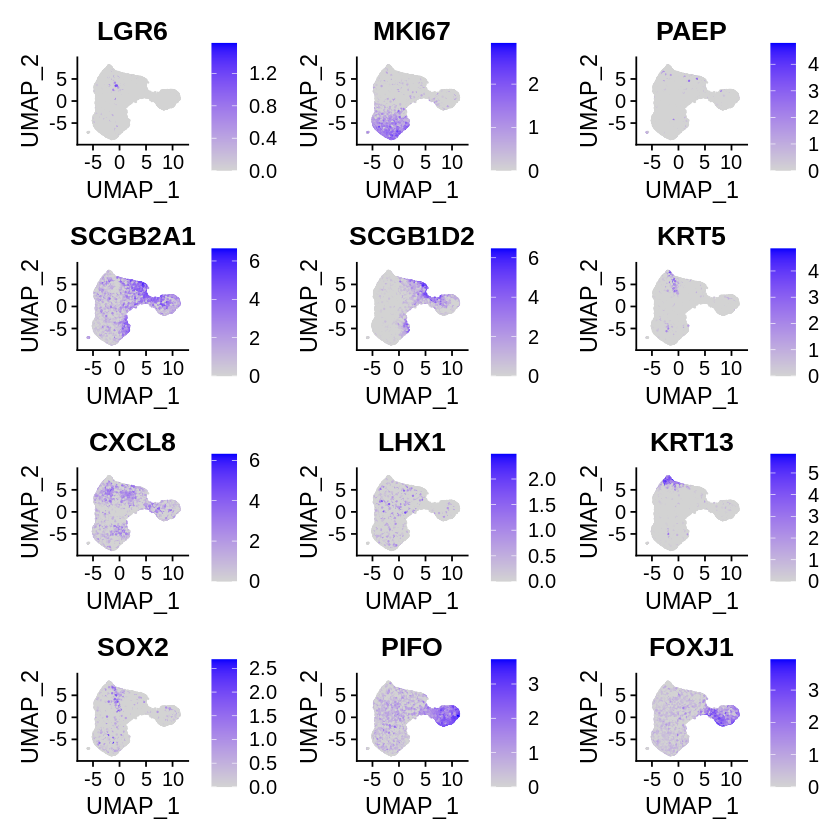

In [31]:
FeaturePlot(anndata, features = known_genes, ncol = 3)
ggsave(filename = paste0('~/farm/endometrium/figures_both_organoid/seurat_markers.png'))

In [32]:
#save
saveRDS(anndata, file = '~/farm/endometrium/figures_both_organoid/seurat2slingshot.rds')

# Slingshot

In [33]:
# Filter HVGs and conver to SingleCellExperiment 
HVGs_anndata = subset(anndata, features = VariableFeatures(object = anndata))
anndata_sce <- as.SingleCellExperiment(HVGs_anndata)

In [ ]:
## Run slingshot
# Slingshot is a two step process 
# 1) identifying the global lineage structure with a cluster-based minimum spanning tree (MST) and 
# 2) fitting simultaneous principal curves to describe each lineage.
# Inputs: a reduced dimensional matrix of coordinates and a set of cluster labels.
slingshot_anndata <- slingshot(anndata_sce, clusterLabels = 'leiden', reducedDim = 'UMAP', start.clus = '6')
SlingshotDataSet(slingshot_anndata)
saveRDS(slingshot_anndata, file = '~/farm/endometrium/figures_both_organoid/slingshot.rds')

Using full covariance matrix

Warning message in if (class(X) == "dist") X <- as.matrix(X):
“the condition has length > 1 and only the first element will be used”


In [ ]:
# slingshot_anndata = readRDS(file = '~/farm/endometrium/figures_both_organoid/slingshot.rds')

In [ ]:
# Visualize the lineage 1
summary(slingshot_anndata$slingPseudotime_1)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(slingshot_anndata$slingPseudotime_1, breaks=100)]
plot(reducedDims(slingshot_anndata)$UMAP, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(slingshot_anndata), lwd=2, col='black')

In [ ]:
# See how the lineage structure was estimated by the cluster-based minimum spanning tree
dev.off()
pdf(file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineages.pdf'), height = 10)
plot(reducedDims(slingshot_anndata)$UMAP, col = brewer.pal(9,'Set1')[slingshot_anndata$leiden+1], pch=16, asp = 1, main = 'leiden')
lines(SlingshotDataSet(slingshot_anndata), lwd=2, type = 'lineages', col = 'black')
plot(reducedDims(slingshot_anndata)$UMAP, col = brewer.pal(11,'Paired')[as.numeric(slingshot_anndata$seurat_clusters)], pch=16, asp = 1, main = 'seurat_clusters')
lines(SlingshotDataSet(slingshot_anndata), lwd=2, type = 'lineages', col = 'black')
dev.off()
SlingshotDataSet(slingshot_anndata)

# DEGs in lineages

In [ ]:
### DEGs over time
SlingshotDataSet(slingshot_anndata)
lineages = grep(names(slingshot_anndata@colData), pattern = 'slingPseudotime_', value = T)

In [ ]:
# Working on lineage 1
lineage_index = 1

In [ ]:
# Filter object to contain only 1 lineage
clusters_in_lineage = SlingshotDataSet(slingshot_anndata)@lineages[[lineage_index]]
cells_in_lineage = which(as.character(slingshot_anndata@colData$seurat_clusters) %in% clusters_in_lineage)
lineage_slingshot = slingshot_anndata[, cells_in_lineage]

In [ ]:
# Extract time and gene expression values (scaled)
t <- lineage_slingshot@colData[, lineages[lineage_index] ]
Y <- subset(HVGs_anndata, cells = rownames(slingshot_anndata@colData)[cells_in_lineage] )@assays$RNA@scale.data

In [ ]:
all(rownames(lineage_slingshot@colData) == colnames(Y))
Y = Y[, !is.na(t)]
t = t[!is.na(t)]

In [ ]:
# For time effiency, only test the most variable genes
# Downsample clusters to ensure even representation of all the stages
sampling = list()
for (i in 1:100){
  random_cells = lapply(clusters_in_lineage, function(cl) sample(colnames(lineage_slingshot)[ lineage_slingshot$seurat_clusters == cl], size = 50, replace = T)  )
  random_cells = unlist(random_cells) %>% unique(.)
  var100 = VariableFeatures(FindVariableFeatures(subset(HVGs_anndata, cells = random_cells), nfeatures = 1000)) #head(names(sort(apply(Y[, random_cells],1,var),decreasing = TRUE)), n=1000)
  sampling[[i]] = var100
}
table(unlist(sampling))[ known_genes ]
frequent_genes = names(which(table(unlist(sampling)) > 90 ))
# Remove mito and ribo genes
frequent_genes = grep('^MT-', frequent_genes, value = T, invert = T)
frequent_genes = grep('^RPS', frequent_genes, value = T, invert = T)
frequent_genes = grep('^RPL', frequent_genes, value = T, invert = T)
intersect(frequent_genes, known_genes)
length(frequent_genes)
frequent_genes = unique(c(frequent_genes, 'LGR6'))

In [ ]:
frequent_genes = intersect(frequent_genes, rownames(Y))
Y <- Y[frequent_genes,]
intersect(frequent_genes, known_genes)

In [ ]:
# fit a GAM with a loess term for pseudotime
gam_test  <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  suppressWarnings({
    tmp <- suppressWarnings(gam(z ~ lo(t), data=d))
  })
  p <- c(tmp$coefficients[2], # statistic
         summary(tmp)[3][[1]][2,3]) # pvalue
  p
})

In [ ]:
## Visualize
# pick out the top genes based on p-value and statistic
gam.stat = gam_test[1,]
gam.pval = gam_test[2,]
gam_test[, colnames(gam_test) %in% known_genes]
gam_test_sign = gam_test[ , gam.pval <= 1e-6  ]
topgenes <- names(which(abs(gam.stat) > 0.05))
intersect(topgenes, known_genes)
length(topgenes)

In [ ]:
# prepare data for plotting
# order genes expression over lineage pseudotime with a heatmap
heatdata <- Y[ topgenes, order(t, na.last = NA)]
# order leiden_K ids as well
heatclus <- lineage_slingshot$seurat_clusters[order(t)]
#heatmap(as.matrix(heatdata), Colv = NA, scale = 'none', ColSideColors = brewer.pal(9,"Set1")[heatclus+1])
annotation_col = as.data.frame(as.factor(heatclus))
rownames(annotation_col) = colnames(lineage_slingshot)[order(t, na.last = NA)]
names(annotation_col) = 'seurat_clusters'

In [ ]:
# plot heatmap with genes sorted according their Pearson correlation
dev.off()
pdf(file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'.pdf'), height = 10)
out = pheatmap(as.matrix(heatdata),  scale = 'none', 
#                color = colorRampPalette(c("white", "firebrick3"))(50),
               clustering_distance_rows= "correlation", cutree_rows = 7,
               annotation_col = annotation_col, show_colnames = F, cluster_cols=F, 
               fontsize_row = 6)
dev.off()
out

In [ ]:
# Group genes in cluster for gene set enrichment
# Extract gene groups from the previous gene dendogram
gene_clusters = as.data.frame(sort(cutree(out$tree_row, k=7)))
names(gene_clusters) = 'group'
table(gene_clusters$group)
gene_clusters$group = as.factor(gene_clusters$group)
write.table(gene_clusters, file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups.txt'), quote = F, sep = '\t')

In [ ]:
dev.off()
# plot heatmap again with gene_clusters labels
pdf(file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_GeneClusters.pdf'), height = 10)
pheatmap(as.matrix(heatdata),  scale = 'none', 
#                color = colorRampPalette(c("white", "firebrick3"))(50),
               clustering_distance_rows= "correlation", annotation_row = gene_clusters, cutree_rows = 10,
               annotation_col = annotation_col, show_colnames = F, cluster_cols=F, 
               fontsize_row = 6)
dev.off()

### GSA on the DES along the trajectory

In [ ]:
library(piano)
library(reshape2)

In [ ]:
# Load genesets and filter those with > 2 genes in the anndata
genesets = readRDS(file = '~/farm/gsea/genesets/all_genesets.rds')
# genesetsf = lapply(genesets, intersect, allgenes)
genesetsf = lapply(genesets, intersect, rownames(HVGs_anndata))
genesetsf = genesetsf[ sapply(genesetsf, length) > 2 ]
gsc <- loadGSC(melt(genesetsf))
background_genes = intersect(allgenes, unlist(genesetsf))

In [ ]:
gene_clusters$gene = rownames(gene_clusters)
# Compute enrichment gene_clusters
groups_of_interest = names(which(table(gene_clusters$group) >= 3))
results = list()
message('N genesets ', length(genesetsf))
message('N clusters ', length(groups_of_interest))
for ( gr in groups_of_interest ){
      print(gr)
      genes = subset(gene_clusters, group == gr)$gene
      x  = runGSAhyper(genes, gsc = gsc, universe = setdiff(background_genes, genes), gsSizeLim = c(3, 500))
      ORx = sapply(x$contingencyTable, function (ct) (ct[1,1]*ct[2,2]) / (ct[1,2]*ct[2,1]) )
      sig_idx =  which(x$pvalues < 0.001)
      if(sum(x$pvalues < 0.001) >  1){
        results[[gr]]  = data.frame(x$resTab[sig_idx, 1:4], OR= ORx[ sig_idx ], gr = gr, genes = paste(genes, collapse = ','))
        results[[gr]]$term = names(x$gsc)[ sig_idx ]
      }
      if(sum(x$pvalues < 0.001) ==  1){
        results[[gr]]  = data.frame(t(x$resTab[ sig_idx, 1:4]), OR= ORx[ sig_idx ], gr = gr, genes = paste(genes, collapse = ','))
        results[[gr]]$term = names(x$gsc)[ sig_idx ]
      }
}

In [ ]:
# Format output
df = do.call(rbind, results)
df = df[ df$Significant..in.gene.set. >= 2 , ]
rownames(df)= NULL
write.table(df, file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups_GSA.txt'), quote = F, sep = '\t')
df[ df$p.value < 0.001, c(6,1,5,8)]

In [ ]:
df$logOR = log2(df$OR)
names(df)[3] = 'N'

In [ ]:
df$term_clean = sapply(strsplit(df$term, split = "::"), head, 1)
df$term_clean = lapply(strsplit(df$term_clean, split = "_"), head, 10) %>% sapply(., paste, collapse=' ')
ggplot(df[df$p.value < 0.001, ], aes(y=term_clean, x=logOR, color = p.value, size = N) ) + geom_point() + 
    facet_grid(gr~., scales = "free_y", space = "free_y") + 
    scale_color_gradientn(colours=rainbow(2)) +
    theme(legend.position = "bottom" )
ggsave(paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups_GSA.png'), width = 10, height = 10)